In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, timedelta
from statistics import mean, mode, median
import math, pickle

In [91]:
df_full = pd.read_csv("./time_stamp_full.csv")
df_full.head()

,filename,date,time,epoch,seqNo
0,/opt2/sedgwick/images/2013/07/Main_2013-07-13_...,2013-07-13,00:00:00,1373673600,0
1,/opt2/sedgwick/images/2013/07/Main_2013-07-13_...,2013-07-13,15:44:14,1373730254,1
2,/opt2/sedgwick/images/2013/07/Main_2013-07-13_...,2013-07-13,15:44:15,1373730255,2
3,/opt2/sedgwick/images/2013/07/Main_2013-07-13_...,2013-07-13,15:44:16,1373730256,3
4,/opt2/sedgwick/images/2013/07/Main_2013-07-13_...,2013-07-13,15:44:16,1373730256,4


In [165]:
# Last epoch - first epoch (1484524799 - 1373673600)

offset = df_full['epoch'][0]
length = df_full['epoch'][len(df_full) - 1] - df_full['epoch'][0] + 1
arr = [0] * length
# arr = [[0] for i in range(length)]

In [53]:
arr1 = [0] * 10
arr2 = [[0] for i in range(10)]
print(arr1)
print(arr2)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]


### DataFrame overhead kills kernel
```
# DataFrame overhead kills kernel

df_time_series = pd.DataFrame(data=data)
for idx, epoch in df_full['epoch'].items():
    df_time_series[epoch - offset] = 1
```

In [166]:
time_series = np.array(arr)

In [167]:
%%time
for idx, epoch in df_full['epoch'].items():
    time_series[epoch - offset] += 1

CPU times: user 738 ms, sys: 30.7 ms, total: 769 ms
Wall time: 791 ms


CPU times: user 5.52 s, sys: 4.1 s, total: 9.62 s
Wall time: 11.8 s


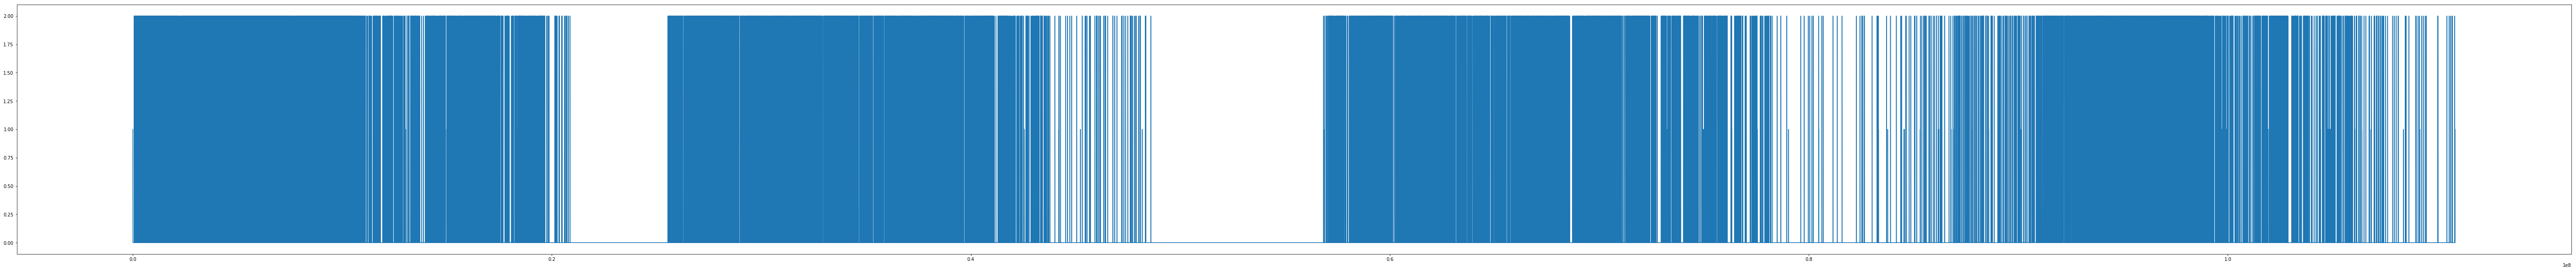

In [170]:
%%time

plt.figure(figsize=[100,10])
plt.plot(time_series)

## Dataset metrics

In [171]:
firstDay = datetime.strptime(df_full['date'][0], "%Y-%m-%d").date()
lastDay = datetime.strptime(df_full['date'][len(df_full) - 1], "%Y-%m-%d").date()

print ("First day of time series: ", firstDay)
print ("Last day of time series: ", lastDay)
print ("Number of days : {0} days".format((lastDay - firstDay).days))
print ("Number of images : ", len(df_full))
print ("Daily mean of images : ", math.ceil(len(df_full) / (lastDay-firstDay).days))

First day of time series:  2013-07-13
Last day of time series:  2017-01-15
Number of days : 1282 days
Number of images :  682076
Daily mean of images :  533


## Spectrogram of daily frequency

In [172]:
def plotDaily(day=1):
    secInADay = 86400
    Start = 1 * day
    End = (Start + secInADay) * day
    
    plt.figure(figsize=[60, 10])
    plt.xlabel("Day {0}".format(day))
    plt.plot(time_series[Start:End])

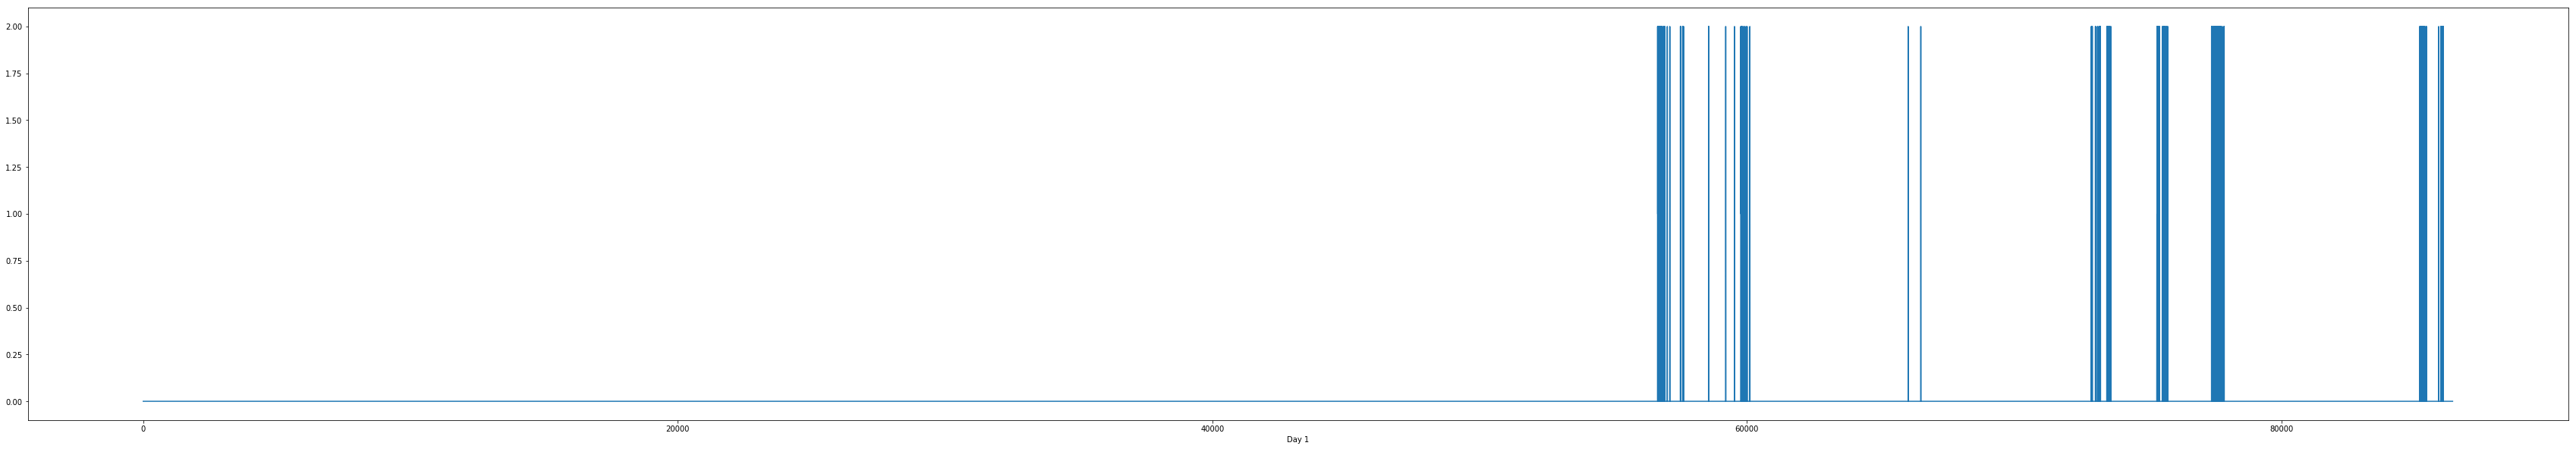

In [173]:
plotDaily(1)

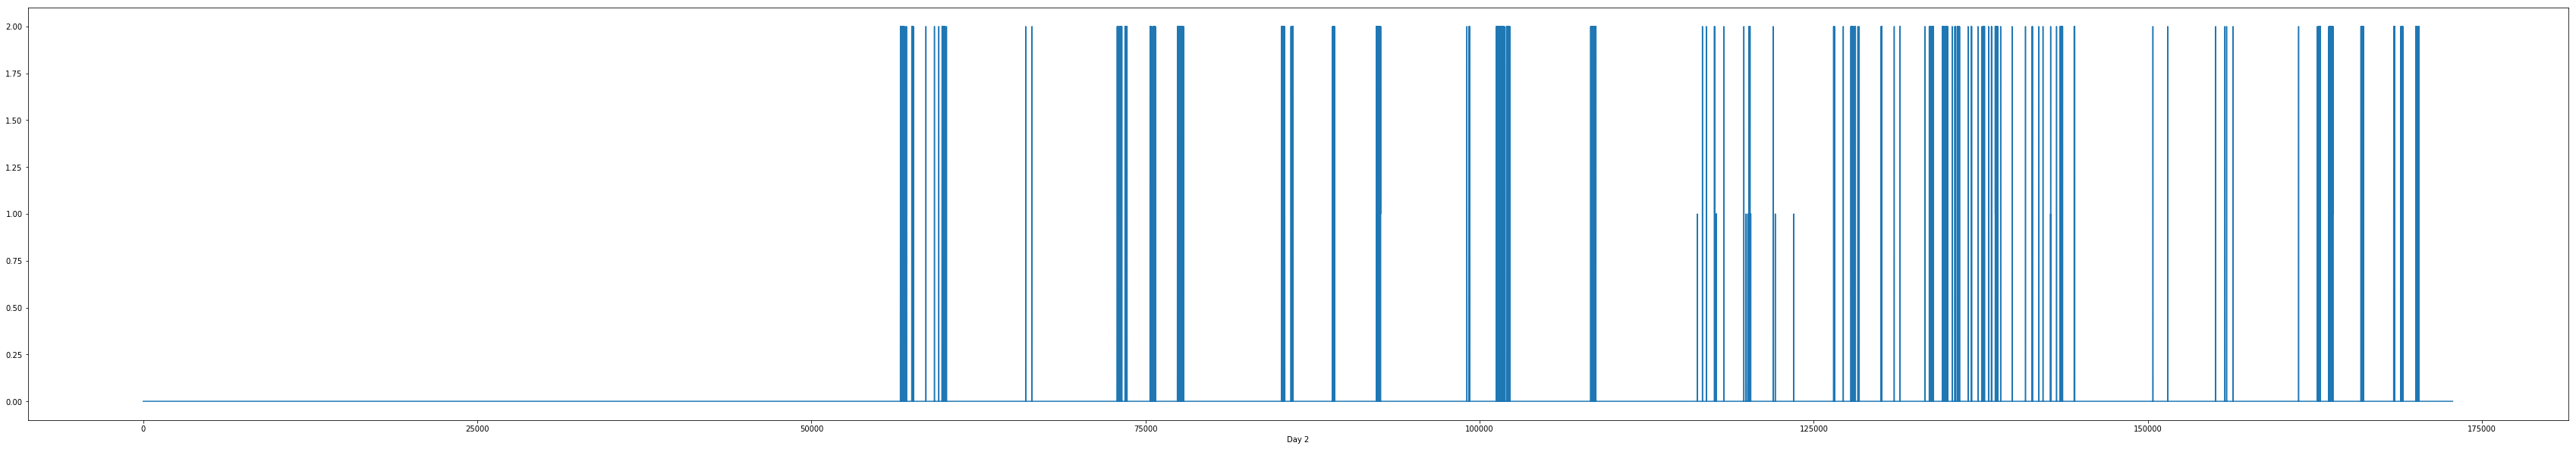

In [174]:
plotDaily(2)

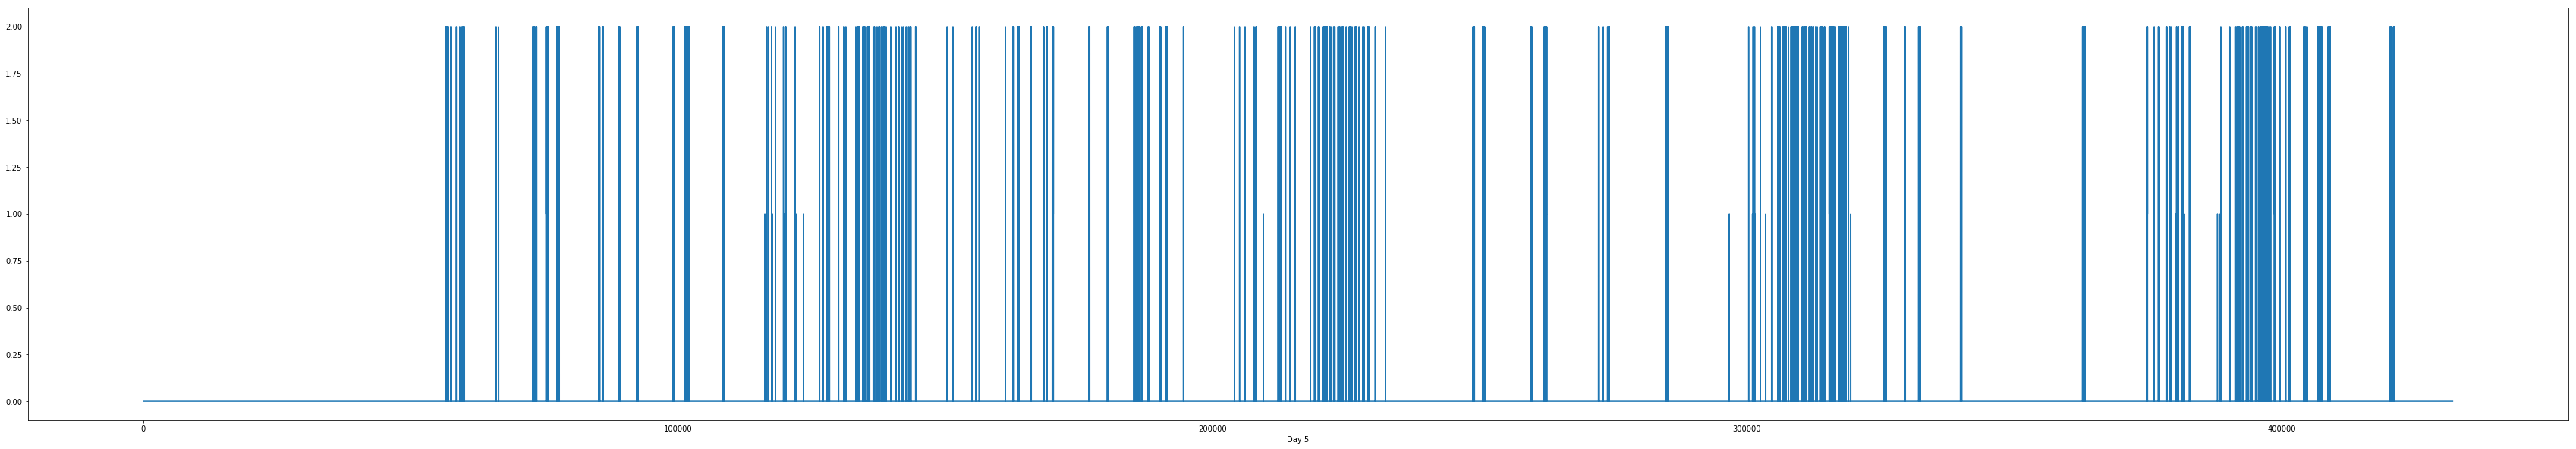

In [175]:
plotDaily(5)

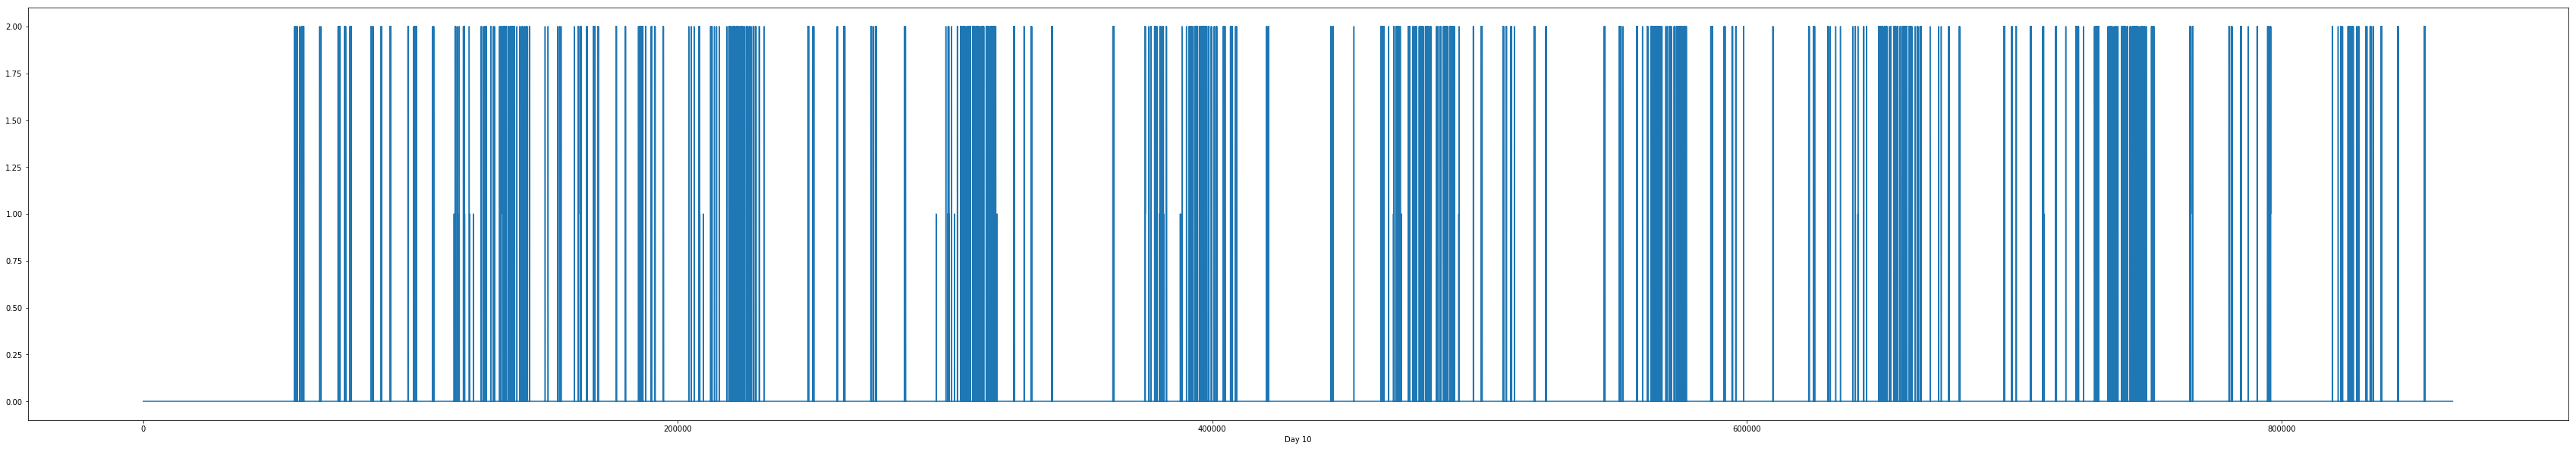

In [176]:
plotDaily(10)

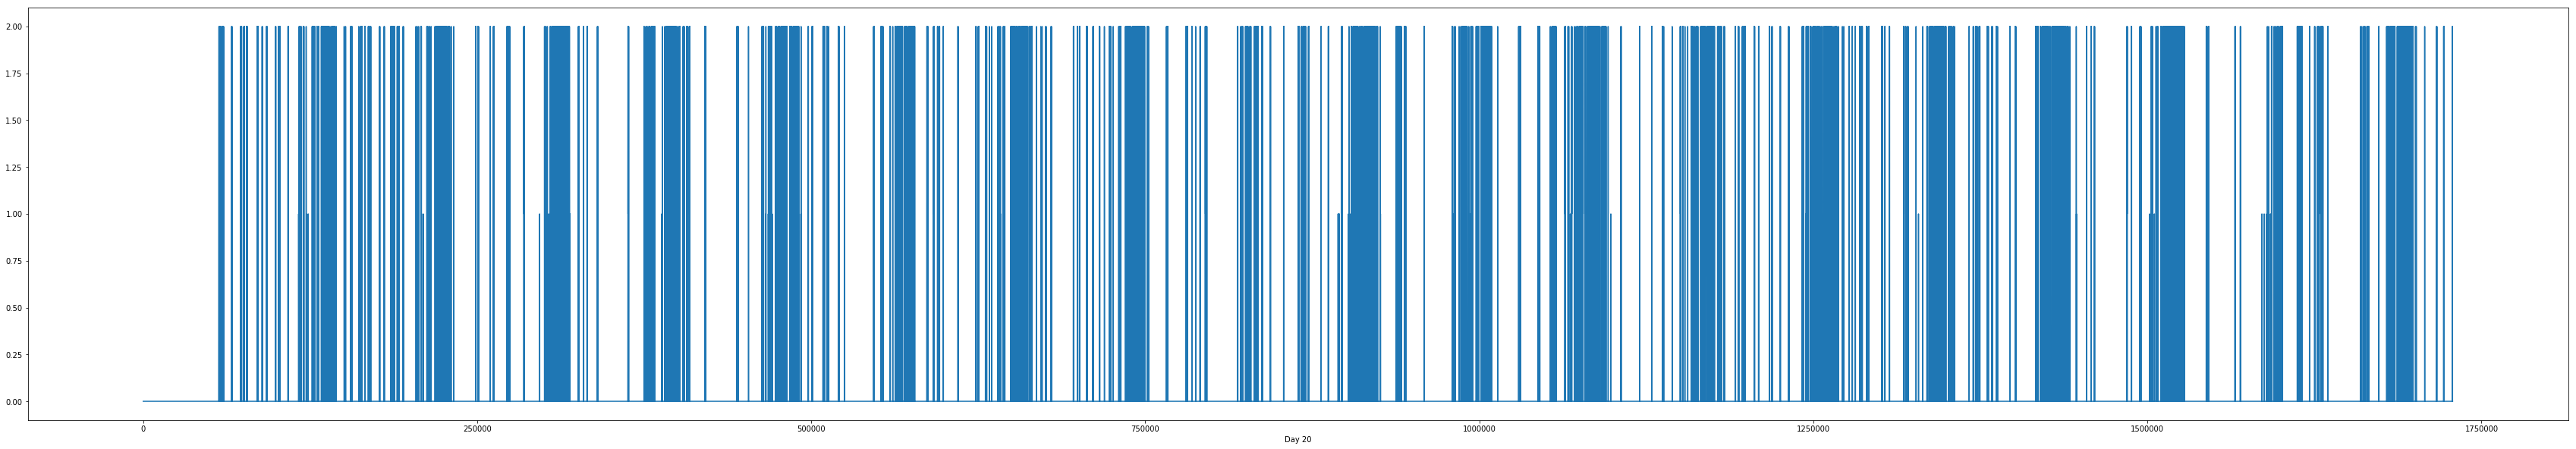

In [177]:
plotDaily(20)

## Fitting Distribution

In [117]:
def distri():
    secInADay = 86400
    counter = 0
    daily_distr = []
    for idx, _ in enumerate(time_series):
        counter = counter + int(time_series[idx])
        if (idx % secInADay == 0):
            daily_distr.append(counter)
            counter = 0
    return daily_distr

In [178]:
daily_distri = distri()

## Plotting Distribution

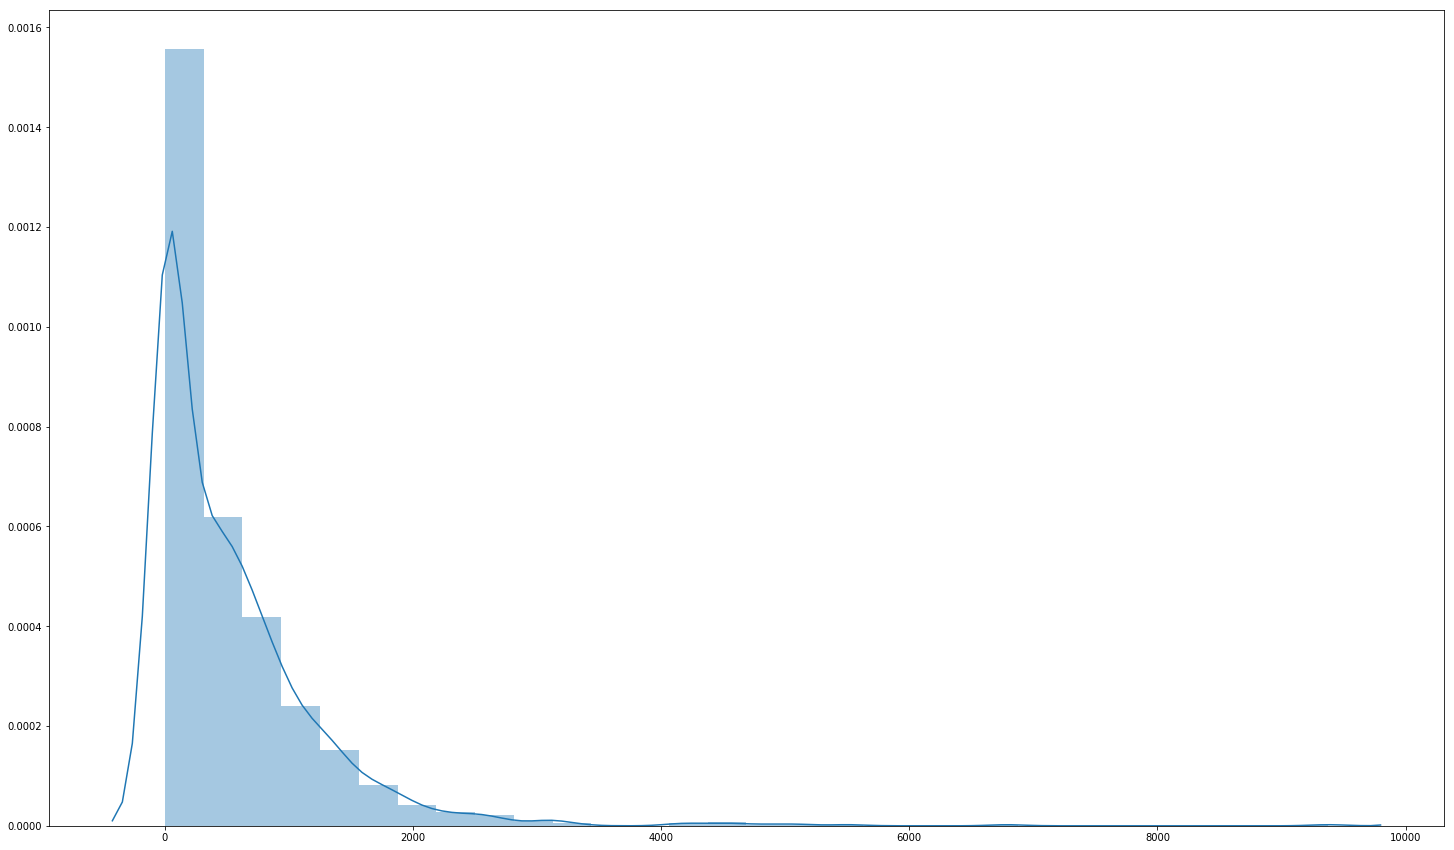

In [179]:
plt.figure(figsize=(25, 15))
sns.distplot(daily_distri, hist=True, bins=int(30))

## Parameterize the distribution


### Exponential Distribution
\begin{align}
PDF = \lambda e^{-\lambda x} \\
Mean = \frac{1}{\lambda} \\
Median = (ln2) / \lambda
\end{align}

In [219]:
def metrics(arr):
    print ("Data points: {0} ".format(len(arr)))
    print ("Maximum image number : {0}".format(max(arr)))
    print ("Minimum image number : {0}".format(min(arr)))
    print ("Mean image number : {0}".format(math.floor(mean(arr))))
    print ("Median image number : {0}".format(median(arr)))
    print ("Mode image number : {0}".format(mode(arr)))

In [220]:
metrics(daily_distri)

Data points: 1283 
Maximum image number : 9375
Minimum image number : 0
Mean image number : 531
Median image number : 335
Mode image number : 0


In [181]:
_lambda = 1 / mean(daily_distri)
_lambda2 = (np.log(2)) / median(daily_distri)
print ("lambda candidate 1: {0}".format(_lambda))
print ("lambda candidate 2: {0}".format(_lambda2))

lambda candidate 1: 0.0018810386030759308
lambda candidate 2: 0.002069096061372971


### Hourly distribution
Matrix - [24] * [1283]

In [182]:
def hourly_distri():
    secs_in_an_hour = 3600
    secs_in_a_day = 86400
    counter = 0
    row = 0
    col = 0
    arr_hourly = [[0] * 24 ] * math.ceil(len(time_series) / secs_in_a_day)
    hourly_matrix = np.array(arr_hourly)
    for idx, _ in enumerate(time_series):
        counter = counter + time_series[idx]
        if (idx != 0 and idx % secs_in_an_hour == 0):
            hourly_matrix[row][col] = counter
            counter = 0
            col = col + 1
        if (idx != 0 and idx % secs_in_a_day == 0):
            row = row + 1
            col = 0
    return hourly_matrix

In [183]:
hourly_matrix = hourly_distri()

#### Effective Dates:

2013-07-13 - 2014-03-11 (242 days) 

2014-05-04 - 2015-01-26 (268 days)

2015-05-01 - 2017-01-15 (626 days)

Total days: 1136 days

Exclude: (Slice is exclusive on right end)

2014-03-12 - 2014-05-03 (53 days) [241 - 294]

2015-01-27 - 2015-04-30 (94 days) [562 - 656] - 53 = [509 - 603]

**hourly_matrix_effect** is the hourly distribution of effective days

In [208]:
# Filter all days in the maintainance gap
hourly_matrix_effect = hourly_matrix.copy()
hourly_matrix_effect = np.delete(hourly_matrix_effect, slice(241, 294), 0)
hourly_matrix_effect = np.delete(hourly_matrix_effect, slice(509, 603), 0)
hourly_matrix_effect.shape

(1136, 24)

In [209]:
avg_hourly = np.mean(hourly_matrix_effect, axis=0)

In [210]:
avg_hourly

array([18.30457746, 21.34771127, 19.41285211, 23.97359155, 25.67605634,
       25.95158451, 17.10651408, 19.99119718, 21.00528169, 26.58890845,
       24.56602113, 26.52552817, 39.7790493 , 40.07130282, 37.10651408,
       27.54841549, 19.92253521, 17.7790493 , 21.25792254, 29.91197183,
       37.78697183, 27.14348592, 15.50528169, 16.14700704])

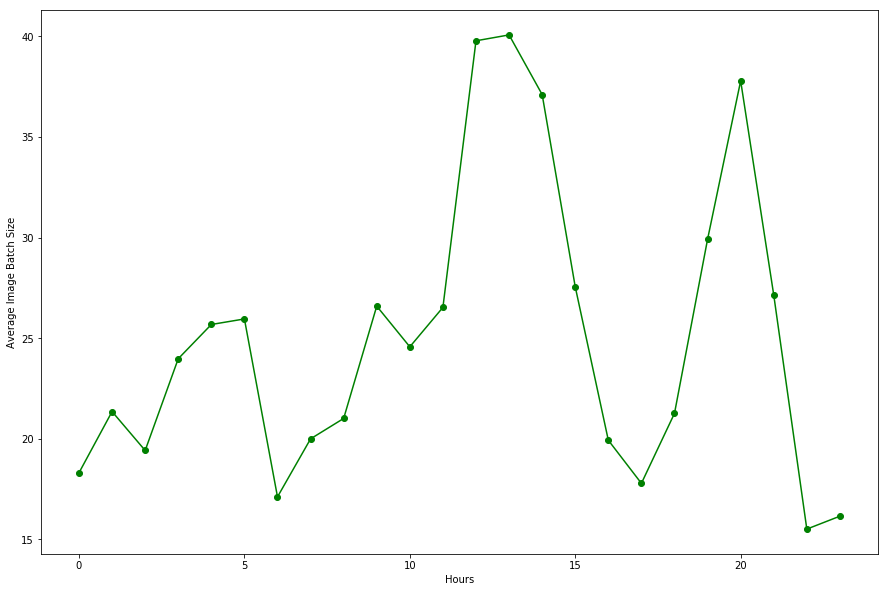

In [211]:
plt.figure(figsize=[15,10])
plt.xlabel("Hours")
plt.ylabel("Average Image Batch Size")
plt.plot(avg_hourly, "go-")

### Empirical CDF


In [249]:
row = hourly_matrix_effect.shape[0]
col = hourly_matrix_effect.shape[1]

hourly_distri = hourly_matrix_effect.reshape(row * col).tolist()

In [250]:
metrics(hourly_distri)

Data points: 27264 
Maximum image number : 2450
Minimum image number : 0
Mean image number : 25
Median image number : 0.0
Mode image number : 0


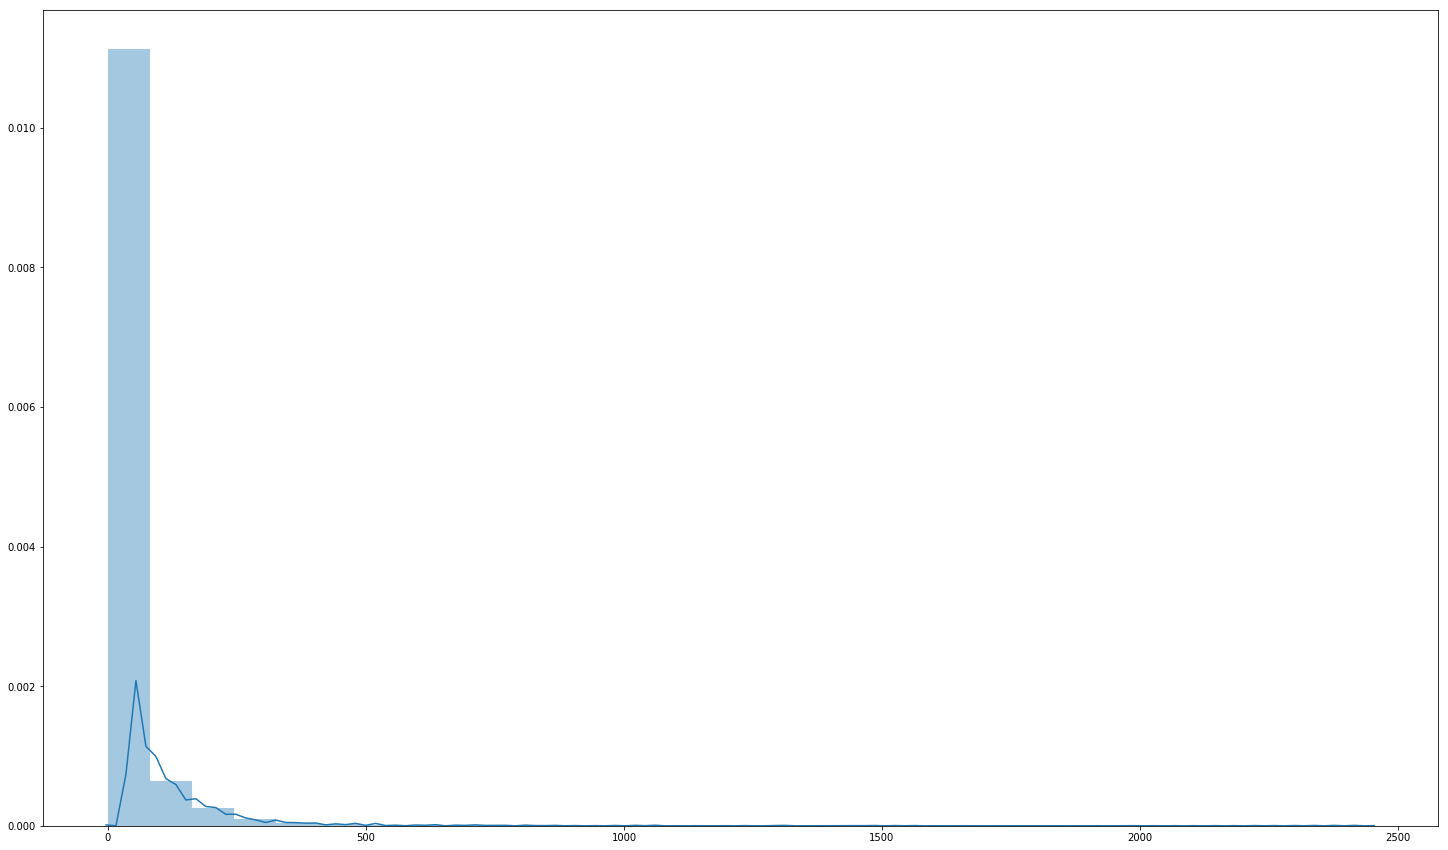

In [251]:
plt.figure(figsize=(25, 15))
sns.distplot(hourly_distri, hist=True, bins=int(30))

In [261]:
# Persist hourly distribution to pickle
with open('hourly_distri.pickle', 'wb') as f:
    pickle.dump(hourly_distri, f)

In [264]:
with open('./hourly_distri.pickle', 'rb') as fp:
    hourly_distri = pickle.load(fp)

In [266]:
from statsmodels.distributions.empirical_distribution import ECDF

In [267]:
ecdf = ECDF(hourly_distri)

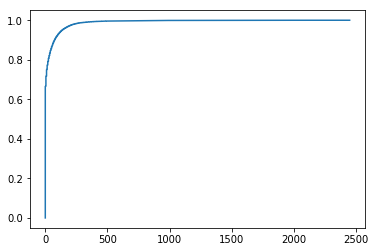

In [274]:
plt.plot(ecdf.x, ecdf.y)

### Conditional ECDF

P(x < K | x > 0)

In [291]:
hourly_distri_cond = []
for v in hourly_distri:
    if (v != 0):
        hourly_distri_cond.append(v)

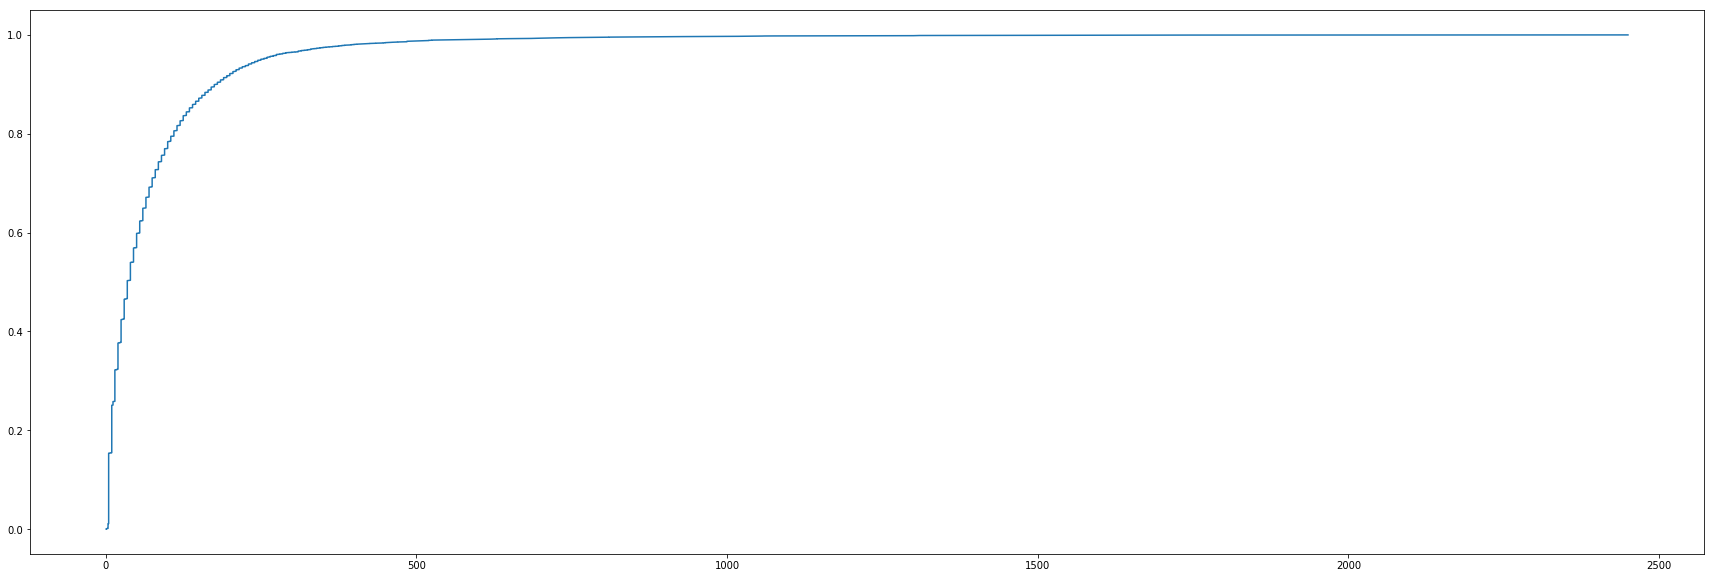

In [297]:
ecdf = ECDF(hourly_distri_cond)
plt.figure(figsize=[30,10])
plt.plot(ecdf.x, ecdf.y)

In [293]:
zero_diff = len(hourly_distri) - len(hourly_distri_cond)
print("{0} hours having zero images in dataset.".format(zero_diff))
print ("{0:.2f} % of total hours have zero images.".format(zero_diff / len(hourly_distri) * 100))

18139 hours having zero images in dataset.
66.53 % of total hours have zero images.


In [294]:
hourly_distri_cond.sort()

In [299]:
hourly_distri_cond[math.ceil(len(hourly_distri_cond) / 2)]

35

In [295]:
# Persist hourly distribution to text file
with open('hourly_distri.txt', 'w') as f:
    for v in hourly_distri_cond:
        if (v != 0):
            f.write("%s, " % v)